# Natural Gradient Optimization of CHSH Nonlocality

In this notebook, the quantum natural gradient is used to maximize nonlocality in the CHSH scenario. 
The quantum natural gradient is a hardware-compatabile gradient optimization technique.
For more details please refer to https://arxiv.org/abs/1909.02108 and this [PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinvh

import context
from QNetOptimizer.gradient_descent import gradient_descent

The CHSH scenario is a simple Bipartite scenario

<div>
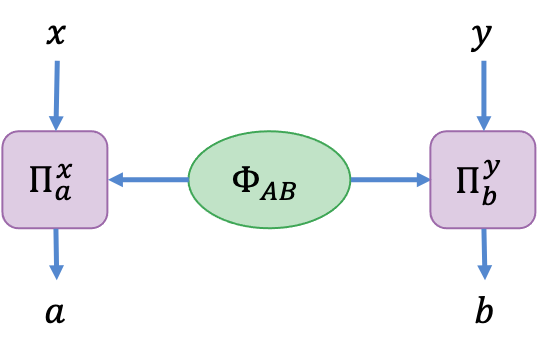
</div>
    
<!-- <img src="images/chsh_scenario.png" alt="chsh scenario" width="200"/> -->

We will perform the natural gradient for both real and general state/measurent parameterizations of this scenario.

In [2]:
# The CHSH scenario only requires two qubits ("a" and "b") to simulate
dev = qml.device("default.qubit", wires=["a", "b"])

@qml.qnode(dev)
def real_chsh_circuit(settings):  
    """
    Ansatz circuit where states and measurents are free to rotate about the y-axis.
    In this model, all quantum states real.

    Args:
        settings (array[float]) : a 4-element array with indices corresponding to
            settings[0] : local RY rotation on Alice's entangled state
            settings[1] : local RY rotation on Bob's entangled state
            settings[2] : local RY rotation on Alices's measurement
            settings[3] : local RY rotation on Bob's measurement
    """
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b"])
        
    qml.RY(settings[0], wires="a")
    qml.RY(settings[1], wires="b")
    
    qml.RY(settings[2], wires="a")
    qml.RY(settings[3], wires="b")
    
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

@qml.qnode(dev)
def arbitrary_chsh_circuit(settings):
    """
    Ansatz circuit where states are prepared with a two-qubit `ArbitraryUnitary` gate and
    measurements are prepared with a one-qubit `ArbitraryUnitary` gate.

    Args:
        settings (array[float]) : a 21-element array with indices corresponding to 
            settings[0:15] : bipartite state parameterization
            settings[15:18] : Alice's local qubit measurement
            settings[18:21] : Bob's local qubit measurement
    """
    state_settings = settings[0:15]
    measurement_a_settings = settings[15:18]
    measurement_b_settings = settings[18:21]
    
    qml.templates.subroutines.ArbitraryUnitary(state_settings, ["a","b"])
    
    qml.templates.subroutines.ArbitraryUnitary(measurement_a_settings, ["a"])
    qml.templates.subroutines.ArbitraryUnitary(measurement_b_settings, ["b"])
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

The cost function for the CHSH scenario is expressed as $B_{CHSH}(\vec{\theta}):=\sum_{x,y\in\{0,1\}} (-1)^{x \wedge y}\langle A(\theta_x, \theta_{\rho_A})B(\phi_y, \theta_{\rho_B})\rangle$ where $\vec{\theta}=(\theta_{\rho_A},\theta_{\rho_B},\theta_0,\theta_1,\phi_0,\phi_1)$. We succintly construct the CHSH cost function for both real and arbitrary with the `_chsh_cost` function.

In [3]:
def _chsh_cost(chsh_circuit):
    """
    Constructs a cost function for the provided CHSH circuit
    """
    def cost(settings):
        score = 0
        for x in [0,1]:
            for y in [0,1]:
                state_settings = settings[0][0][0]

                ϕ_A = settings[1][0][x]
                ϕ_B = settings[1][1][y]

                circ_settings = np.append(state_settings, [ϕ_A, ϕ_B])

                run = chsh_circuit(circ_settings)
                scalar = (-1)**(x*y)

                score += scalar * run

        return -(score)
    
    return cost

real_chsh_cost = _chsh_cost(real_chsh_circuit)
arbitrary_chsh_cost = _chsh_cost(arbitrary_chsh_circuit)

We construct two functions for initializing network settings objects that contain the settings for all simulation parameters for the CHSH scenario.

In [4]:
def zero_settings(prepare_nodes_dims, measure_nodes_dims):
    prepare_settings = []
    for prepare_node_dims in prepare_nodes_dims:
        prepare_settings.append(np.zeros(prepare_node_dims))
    
    measure_settings = []
    for measure_node_dims in measure_nodes_dims:
        measure_settings.append(np.zeros(measure_node_dims))
    
    return [prepare_settings, measure_settings]

def rand_settings(prepare_nodes_dims, measure_nodes_dims):
    prepare_settings = []
    for prepare_node_dims in prepare_nodes_dims:
        node_settings = 2*np.pi*np.random.random(prepare_node_dims) - np.pi
        prepare_settings.append(node_settings)
    
    measure_settings = []
    for measure_node_dims in measure_nodes_dims:
        node_settings = 2*np.pi*np.random.random(measure_node_dims) - np.pi
        measure_settings.append(node_settings)
    
    return [prepare_settings, measure_settings]

The natural gradient $\nabla_{ng}B(\vec{\theta}):= g^{-1}(\vec{\theta})\nabla B(\vec{\theta})$ simply scales the euclidean gradient $\nabla$ by the pseudo-inverse of the Fubini-Study metric tensor $g^{-1}(\vec{\theta})$.
The natural gradient of the $B_{CHSH}(\vec{\theta})$ cost function is found to be

$$
\begin{align}
    \nabla_{ng}B_{CHSH}(\vec{\theta})  &= \nabla_{ng}\sum_{x,y\in\{0,1\}}(-1)^{x \wedge y}\langle A(\theta_x, \theta_{\rho_A})B(\phi_y, \theta_{\rho_B})\rangle \\
    &= \sum_{x,y\in\{0,1\}}(-1)^{x \wedge y}\nabla_{ng}\langle A(\theta_x, \theta_{\rho_A})B(\phi_y, \theta_{\rho_B})\rangle \\
    &= \sum_{x,y\in\{0,1\}}(-1)^{x \wedge y}g^{-1}(\theta_{\rho_A},\theta_{\rho_B},\theta_x,\phi_y)\nabla\langle A(\theta_x, \theta_{\rho_A})B(\phi_y, \theta_{\rho_B})\rangle
\end{align}.
$$

The final line of this expression shows how the natural gradient $\nabla_{ng}$ can be recast in terms of the euclidean gradient $\nabla$.
In PennyLane, the natural gradient can't be evaluated for the $B_{CHSH}$ cost function because it requires the combination of results from different observables.
Fortunately, the natural gradient can still be computed manually by writing a specialized `grad_fn` function for the `GradientDescentoptimizer` (see [this PennyLane discussion post](https://discuss.pennylane.ai/t/variational-classifiers-and-qngoptimizer/524/2) for details).
It is important to note that the $g^{-1}(\theta_{\rho_A},\theta_{\rho_B},\theta_x,\phi_y)\nabla\langle A(\theta_x, \theta_{\rho_A})B(\phi_y, \theta_{\rho_B})\rangle$ is implemented as a 4-element array which is then cast to the appropriate indices of the parameters $\vec{\theta}$.

In [5]:
def _chsh_ng(chsh_circuit, prepare_nodes_dims, measure_nodes_dims):
    
    def natural_grad(settings):
        quantum_grad = qml.grad(chsh_circuit)
        
        grad = zero_settings(prepare_nodes_dims, measure_nodes_dims)
        for x in [0,1]:
            for y in [0,1]:

                state_settings = settings[0][0][0]

                ϕ_A = settings[1][0][x]
                ϕ_B = settings[1][1][y]

                circ_settings = np.append(state_settings, [ϕ_A, ϕ_B])
                qgrad = quantum_grad(circ_settings)
                ginv = pinvh(chsh_circuit.metric_tensor(circ_settings))

                scalar = -1*(-1)**(x*y)

                nat_grad = scalar * (ginv @ qgrad)

                # remapping states and measurements
                low_set = 0
                up_set = 0
                
                num_settings = prepare_nodes_dims[0][1]
                up_set = num_settings + low_set         
                grad[0][0][0] += nat_grad[low_set:up_set]
                low_set = up_set
                
                num_settings = measure_nodes_dims[0][1]
                up_set = low_set + num_settings
                grad[1][0][x] += nat_grad[low_set:up_set]
                low_set = up_set
                
                num_settings = measure_nodes_dims[1][1]
                up_set = low_set + num_settings
                grad[1][1][y] += nat_grad[low_set:up_set]
                low_set = up_set

        return grad
    return natural_grad

real_chsh_cost_ng = _chsh_ng(real_chsh_circuit, [[1,2]],[[2,1],[2,1]])
arb_chsh_cost_ng = _chsh_ng(arbitrary_chsh_circuit, [[1,15]],[[2,3],[2,3]])

## Optimizing CHSH Nonlocality with Natural Gradient

Now we compare the natural gradient with backpropagation for both real and general CHSH scenario parameterizations.

### Real CHSH Parameterization

In [6]:
real_settings = rand_settings([[1,2]],[[2,1],[2,1]])

ng_opt_dict = gradient_descent(
    real_chsh_cost, real_settings, sample_width=5, step_size=0.1, num_steps=50, verbose=False, grad_fn=real_chsh_cost_ng
)

bp_opt_dict = gradient_descent(
    real_chsh_cost, real_settings, sample_width=5, step_size=0.1, verbose=False, num_steps=50
)

bp_opt_dict2 = gradient_descent(
    real_chsh_cost, real_settings, sample_width=5, step_size=0.2, verbose=False, num_steps=50
)

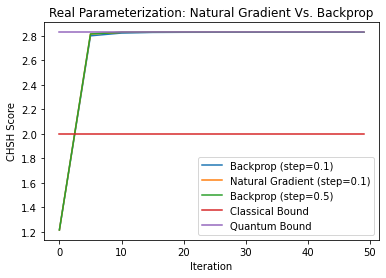

In [7]:
# Plot the score of the CHSH Bell inequality
plt.plot(bp_opt_dict["samples"], bp_opt_dict["scores"], label = "Backprop (step=0.1)")
plt.plot(ng_opt_dict["samples"], ng_opt_dict["scores"], label = "Natural Gradient (step=0.1)")
plt.plot(bp_opt_dict2["samples"], bp_opt_dict2["scores"], label = "Backprop (step=0.5)")
plt.plot(bp_opt_dict["samples"], [2]*len(bp_opt_dict["samples"]), label = "Classical Bound")
plt.plot(bp_opt_dict["samples"], [2*np.sqrt(2)]*len(bp_opt_dict["samples"]), label = "Quantum Bound")
plt.title("Real Parameterization: Natural Gradient Vs. Backprop")
plt.xlabel("Iteration")
plt.ylabel("CHSH Score")
plt.legend()
plt.show()

### General CHSH Parameterization

In [8]:
arb_settings = rand_settings([[1,15]],[[2,3],[2,3]])

ng_arb_opt_dict = gradient_descent(
    arbitrary_chsh_cost, arb_settings, sample_width=5, step_size=0.01, verbose=False, num_steps=50, grad_fn=arb_chsh_cost_ng
)

bp_arb_opt_dict = gradient_descent(
    arbitrary_chsh_cost, arb_settings, sample_width=5, step_size=0.01, verbose=False, num_steps=50
)

bp_arb_opt_dict2 = gradient_descent(
    arbitrary_chsh_cost, arb_settings, sample_width=5, step_size=0.1, verbose=False, num_steps=50
)

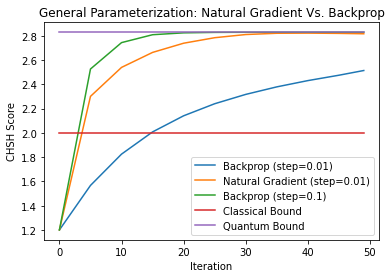

In [9]:
# Plot the score of the CHSH Bell inequality
plt.plot(bp_arb_opt_dict["samples"], bp_arb_opt_dict["scores"], label = "Backprop (step=0.01)")
plt.plot(ng_arb_opt_dict["samples"], ng_arb_opt_dict["scores"], label = "Natural Gradient (step=0.01)")
plt.plot(bp_arb_opt_dict2["samples"], bp_arb_opt_dict2["scores"], label = "Backprop (step=0.1)")
plt.plot(bp_arb_opt_dict["samples"], [2]*len(bp_arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(bp_arb_opt_dict["samples"], [2*np.sqrt(2)]*len(bp_arb_opt_dict["samples"]), label = "Quantum Bound")
plt.title(r"General Parameterization: Natural Gradient Vs. Backprop")
plt.xlabel("Iteration")
plt.ylabel(r"CHSH Score")
plt.legend()
plt.show()

## Scratch Work

In [10]:
def bell_state_RY_ansatz(wires=[0,1]):
    settings_dims = 2
    
    @qml.template
    def ansatz_circuit(settings):
        qml.Hadamard(wires=wires[0])
        qml.CNOT(wires=wires[:2])

        qml.RY(settings[0], wires=wires[0])
        qml.RY(settings[1], wires=wires[1])
    
    ansatz = {
        "circuit" : ansatz_circuit,
        "settings_dims" : 2
    }
    
    return ansatz


def local_RY_ansatz(wires=[0,1]):
    settings_dims = len(wires)
    
    @qml.template
    def ansatz_circuit(settings):
        qml.RY(settings[0], wires=wires[0])
        qml.RY(settings[1], wires=wires[1])
    
    ansatz = {
        "circuit" : ansatz_circuit,
        "settings_dims" : settings_dims
    }
    
    return ansatz

In [11]:
# prepare nodes are a data structure describing the state preparation ansatz
# returns a function that takes settings with dims specified by the prepare settings dims
def prepare_layer(prepare_nodes):
    
    prepare_settings_dims = []
    for node in prepare_nodes:
        ansatz = node["ansatz"](wires=node["wires"])

        node_settings_dims = [node["num_in"]] 
        if isinstance(ansatz["settings_dims"], int):
            node_settings_dims.append(ansatz["settings_dims"])
        else:
            node_settings_dims.extend(ansatz["settings_dims"])
        
        prepare_settings_dims.append(node_settings_dims)
        
    def ansatz_circuit(prepare_settings, classical_inputs):
        for i in range(len(measure_nodes)):
            node = measure_nodes[i]
            classical_input = classical_inputs[i]
            
            print("classical input ", classical_input)
            print("prepare settings i ", prepare_settings[i])
            
            ansatz = node["ansatz"](wires=node["wires"])

            settings = prepare_settings[i][classical_input]
            
            print("settings ", settings)
            ansatz["circuit"](settings)
            
    ansatz = {
        "circuit" : ansatz_circuit,
        "settings_dims" : prepare_settings_dims,
    }
    
    return ansatz
    
# measure_nodes([(num_out = 2, wires=[0], ansatz=RY),(num_out,wires=[1], ansatz=RY)])
# measure nodes are a data structure describing the measurement ansatz
def measure_layer(measure_nodes):
    
    measure_settings_dims = []
    for node in measure_nodes:
        ansatz = node["ansatz"](wires=node["wires"])

        node_settings_dims = [node["num_in"]]
        if isinstance(ansatz["settings_dims"], int):
            node_settings_dims.append(ansatz["settings_dims"])
        else:
            node_settings_dims.extend(ansatz["settings_dims"])
        
        measure_settings_dims.append(node_settings_dims)
    
    def ansatz_circuit(measure_settings, classical_inputs):
        for i in range(len(measure_nodes)):
            node = measure_nodes[i]
            classical_input = classical_inputs[i]
            ansatz = node["ansatz"](wires=node["wires"])
            
            print("classical input ", classical_input)
            print("prepare settings i ", prepare_settings[i])

            settings = measure_settings[i][classical_input]
            
            print("settings ", settings)

            ansatz["circuit"](settings)
        
    
    ansatz = {
        "circuit" : ansatz_circuit,
        "settings_dims" : measure_settings_dims
    }
    
    return ansatz

# make function that takes prepare_settings, measure_settings
# circuit = prepare_nodes + measure_nodes
# a network ansatz knows how to share the dimensions of its accepted settings
def network_ansatz(prepare_nodes,measure_nodes):
    # construct prepare and measure layers
    # describe settings dimensions
    
    print("yoyoyoyoy")
    prepare_ansatz = prepare_layer(prepare_nodes)
    measure_ansatz = measure_layer(measure_nodes)
    
    def ansatz_circuit(settings, classical_inputs):
        (prepare_settings, measure_settings) = settings
        (prepare_inputs, measure_inputs) = classical_inputs
                
        print(prepare_ansatz["settings_dims"])    
            
        prepare_ansatz["circuit"](prepare_settings, prepare_inputs)
        measure_ansatz["circuit"](measure_settings, measure_inputs)
    
    
    
    network_settings_dims = [prepare_ansatz["settings_dims"], measure_ansatz["settings_dims"]]
    
    ansatz = {
        "circuit" : ansatz_circuit,
        "settings_dims" : network_settings_dims
    }
    
    return ansatz


# make a network qnode
def network_qnode(ansatz):
    return
    
# returns a cost(settings) function for the network qnode
def chsh_cost(network_qnode):
    return
    
def chsh_ng(network_cost, network_qnode):
    return
    
### Gradient descent example